Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install 'gym[all]'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [76]:
import aerosandbox as asb
import aerosandbox.numpy as np
#HYPERPARAMS
dX_bounds = (-1, 1) 
dY_bounds = (-1, 1)
dZ_bounds = (-1, 1)
dChord_bounds = (-1, 1)
dTwist_bounds = (-1, 1)
KT_bounds = (0, 10)
KB_bounds = (0, 3)
N_bounds = (1, 10)
LEW_bounds = (0, 5)

numChords = 2
kulfanWeightResolution = 6

# Lower and upper bounds for each of the parameters
low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
vectorLengthPerXSec = len(low)
# Since you have 9 vectors, the action space will be:
low = np.tile(low, numChords)  # Repeating the pattern 9 times
high = np.tile(high, numChords)

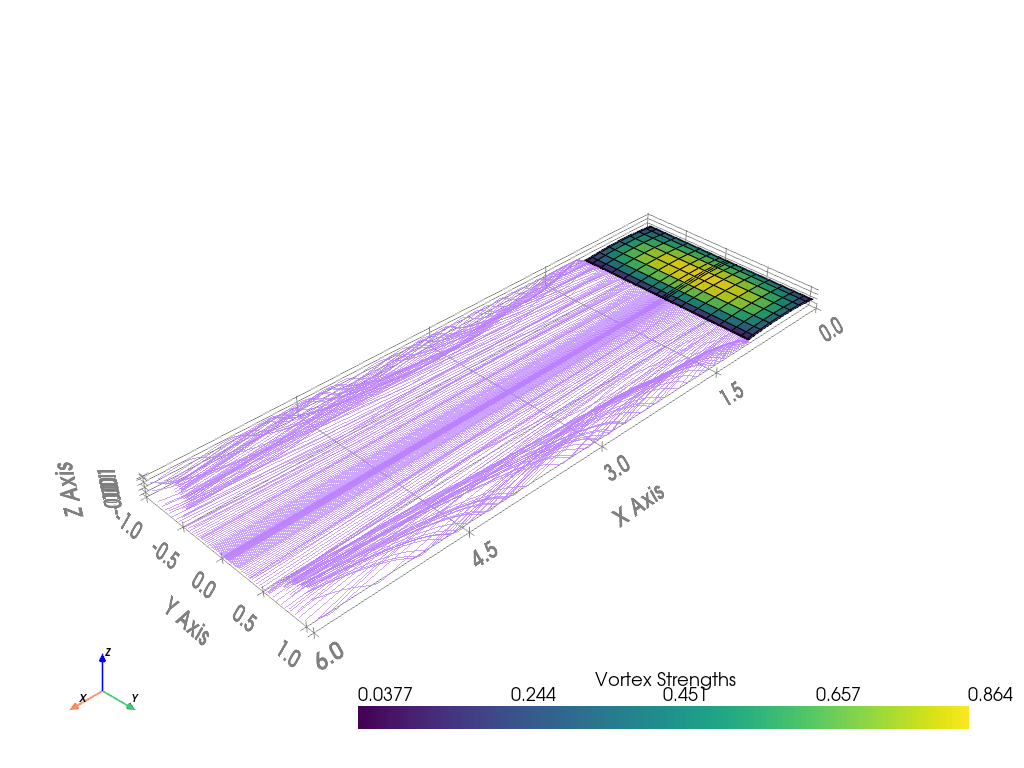

In [77]:
# Initial values for cross sections
init_xyz_le = [[0, i, 0] for i in range(numChords)] #Space chords by 1 initially.
init_chord = [1] * numChords  # Example values
init_twist = [0] * numChords  # Example values
init_upper_weights = [[0.1] * kulfanWeightResolution for _ in range(numChords)]  # Example values
init_lower_weights = [[0.1] * kulfanWeightResolution for _ in range(numChords)]  # Example values
init_leading_edge_weight = [0] * numChords  # Example values
init_N1 = [1] * numChords  # Example values
init_N2 = [1] * numChords  # Example values

xsecs = [asb.WingXSec(
			xyz_le=init_xyz_le[i],
			chord=init_chord[i],
			twist=init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=init_upper_weights[i],
				lower_weights=init_lower_weights[i],
				leading_edge_weight=init_leading_edge_weight[i],
				N1=init_N1[i],
				N2=init_N2[i]
			)
		) for i in range(numChords)]


# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,             # Should this wing be mirrored across the XZ plane?
					xsecs=xsecs
				),
			],
		)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,  # m/s
        alpha=5,  # degree
    )
)
aero = vlm.run()  # Returns a dictionary
vlm.draw(show_kwargs=dict(jupyter_backend="static"))

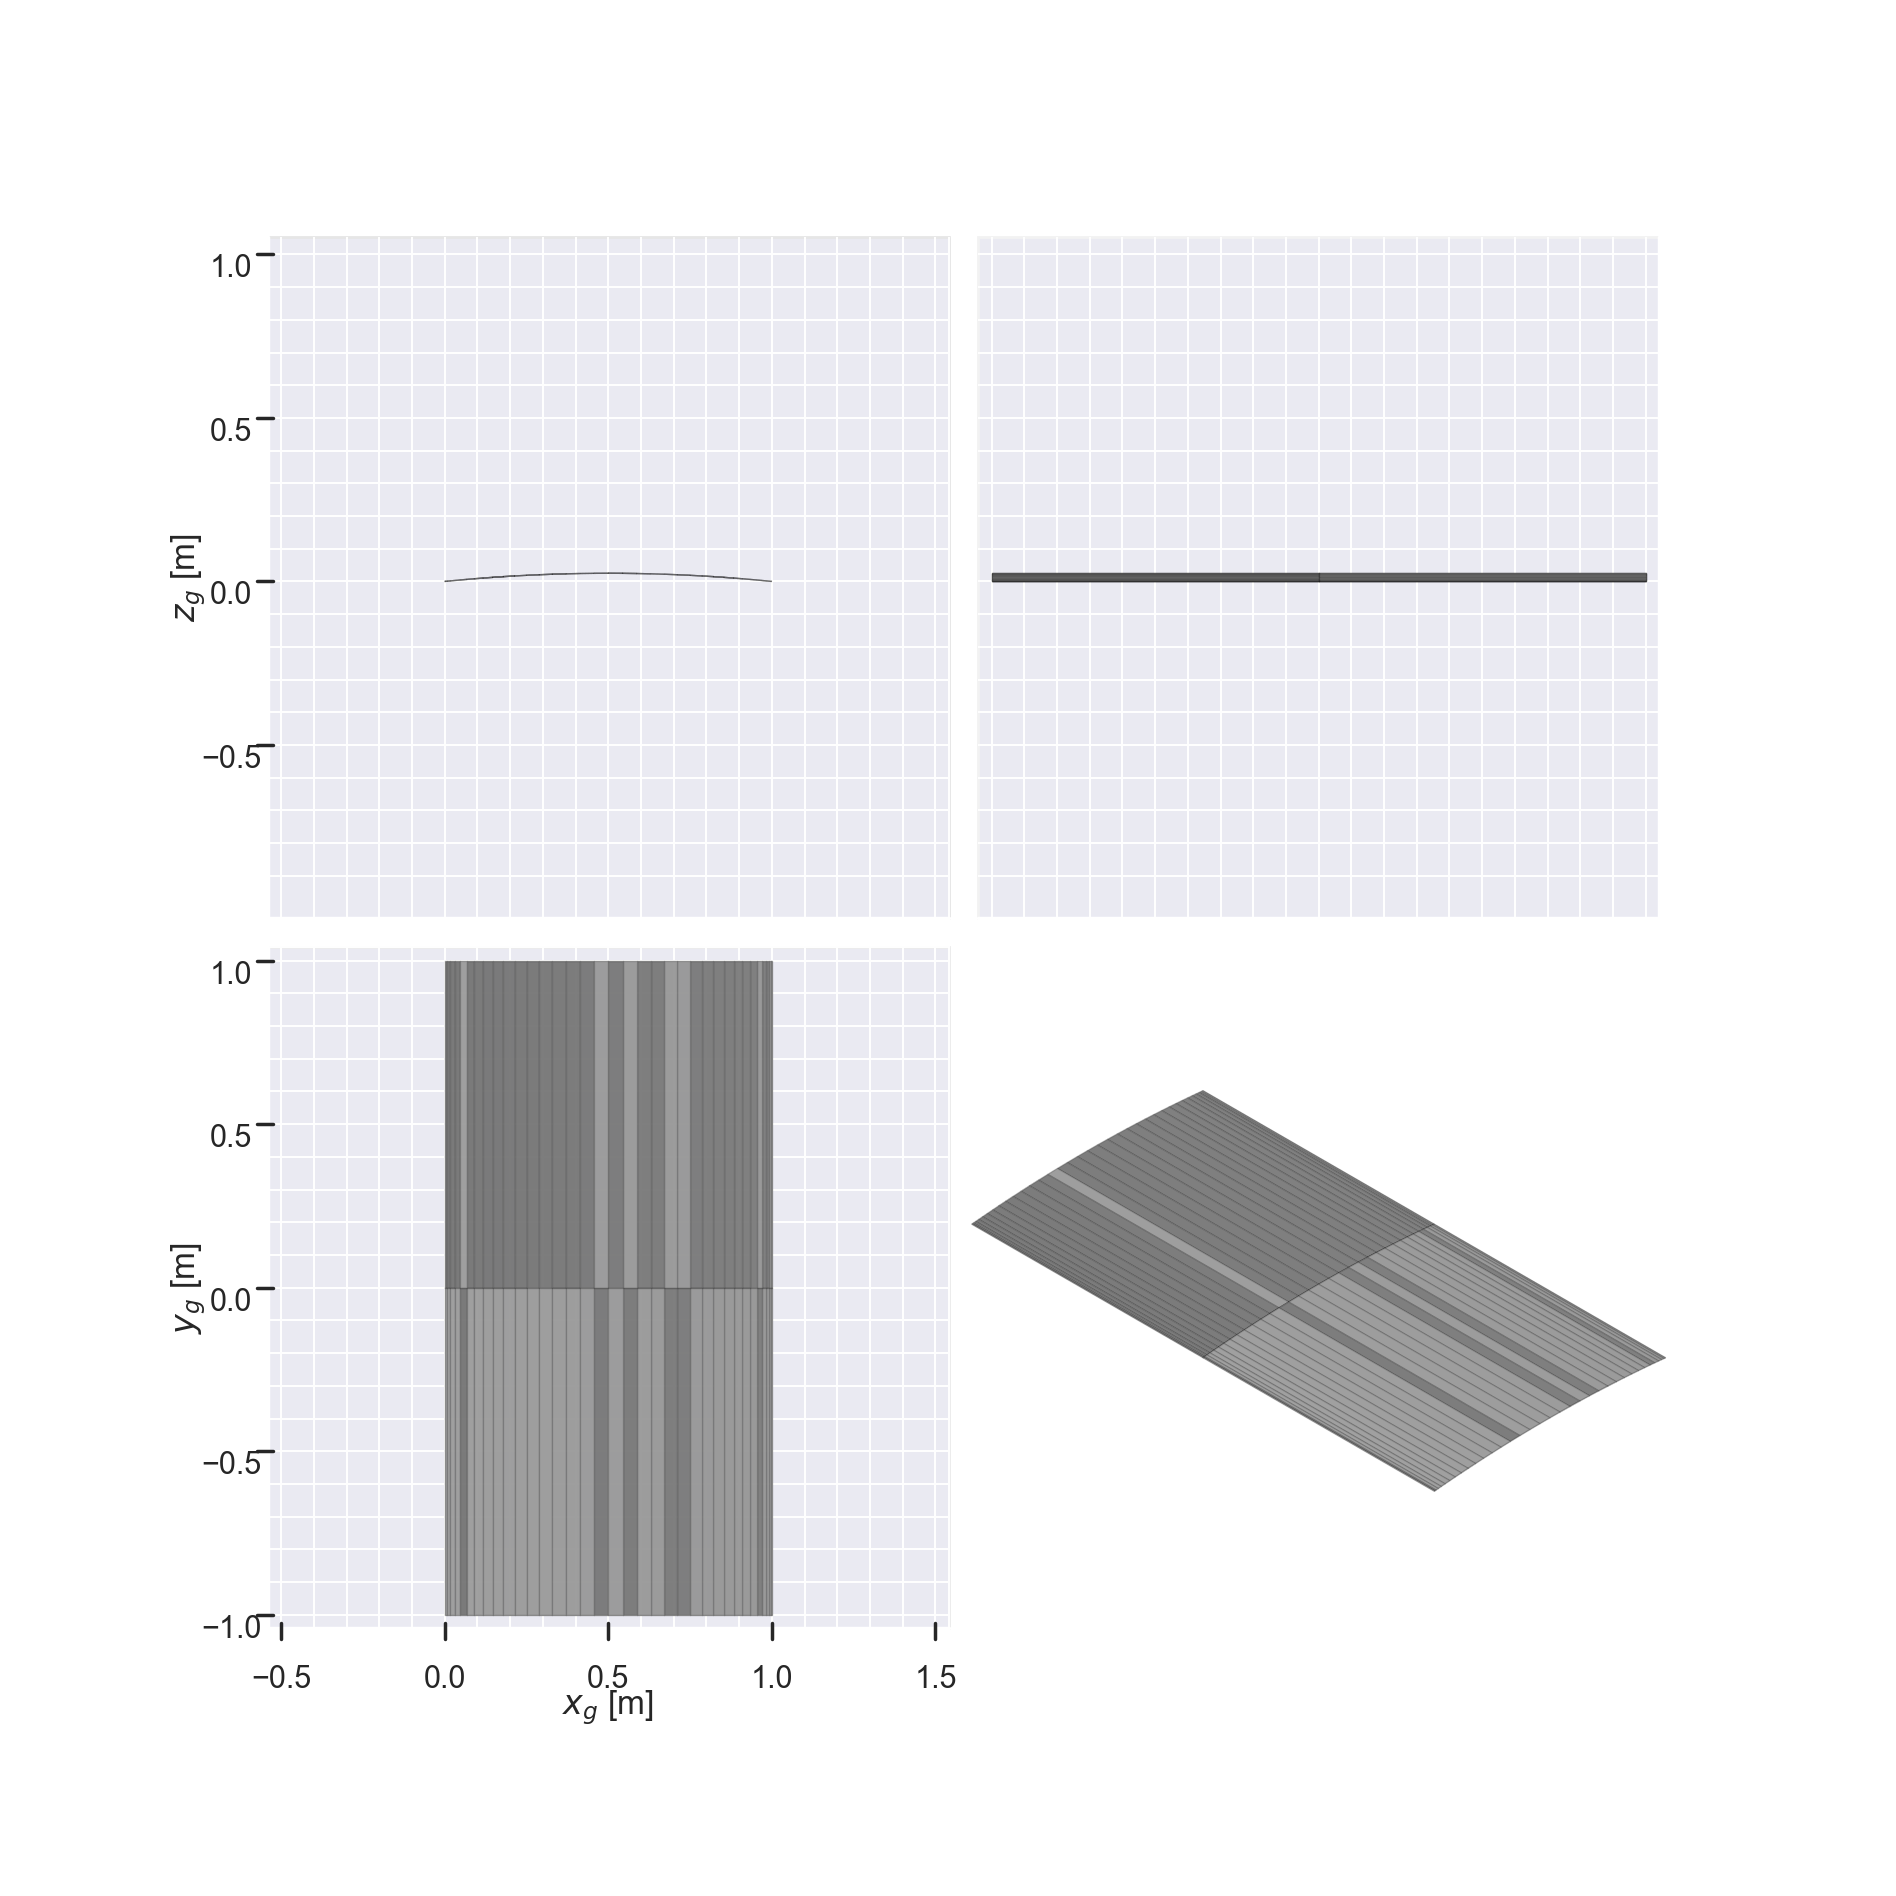

In [78]:
airplane.draw_three_view()

In [90]:
from gym import spaces
import gym
import numpy as np
	
class AeroEnv(gym.Env):
	"""Custom Environment that follows gym interface"""

	def __init__(self):
		super(AeroEnv, self).__init__()

		# Initial values for cross sections
		self.init_xyz_le = [np.array([0, i, 0],np.float64) for i in range(numChords)]							
		self.init_chord = [1] * numChords  														
		self.init_twist = [0] * numChords  														
		self.init_upper_weights = np.array([[0.1] * kulfanWeightResolution for _ in range(numChords)],np.float64)
		self.init_lower_weights = np.array([[0.1] * kulfanWeightResolution for _ in range(numChords)],np.float64)
		self.init_leading_edge_weight = [0] * numChords  										
		self.init_N1 = [1] * numChords 															
		self.init_N2 = [1] * numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		#Initialize action space
		action_space = spaces.Box(low=low, high=high, dtype=np.float64)
		self.action_space = action_space
		self.observation_space = spaces.Box(low=np.array([-10,-10], np.float32), high=np.array([-10,-10], np.float32), # lift coefficient, drag coefficient
											dtype=np.float32)

	def step(self, action):
		for i in range(numChords):
			idx = i * vectorLengthPerXSec
			# Apply dX, dY, dZ
			self.xsecs[i].xyz_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]

			# Apply dChord, dTwist
			self.xsecs[i].chord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			self.xsecs[i].twist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			self.xsecs[i].airfoil.upper_weights = np.array([action[idx + 5 + j] for j in range(kulfanWeightResolution)],np.float64)
			self.xsecs[i].airfoil.lower_weights = np.array([action[idx + 5+kulfanWeightResolution + j] for j in range(kulfanWeightResolution)], np.float64)
			
			# Set LEW, N1, N2
			self.xsecs[i].airfoil.leading_edge_weight = action[idx + 5+2*kulfanWeightResolution] 	# LEW = action's LEW
			self.xsecs[i].airfoil.N1 = action[idx + 6+2*kulfanWeightResolution] 					# N1 = action's N1
			self.xsecs[i].airfoil.N2 = action[idx + 7+2*kulfanWeightResolution]						# N2 = action's N2
		

			for xsec in self.xsecs:
				print("xyz_le:", xsec.xyz_le)
				print("chord:", xsec.chord)
				print("twist:", xsec.twist)
				
				airfoil = xsec.airfoil
				print("Airfoil upper_weights:", airfoil.upper_weights)
				print("Airfoil lower_weights:", airfoil.lower_weights)
				print("Airfoil leading_edge_weight:", airfoil.leading_edge_weight)
				print("Airfoil N1:", airfoil.N1)
				print("Airfoil N2:", airfoil.N2)
				print("-----")

		airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,             # Should this wing be mirrored across the XZ plane?
					xsecs=self.xsecs
				),
			],
		)

		vlm = asb.VortexLatticeMethod(
			airplane=airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = vlm.run()  # Returns a dictionary
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		reward=liftCoeff/dragCoeff
		return [liftCoeff, dragCoeff], reward, reward > 1.4, [liftCoeff, dragCoeff] #last array here is the info object
	
	
	def reset(self):
    # 1. Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]
		# TODO: Introduce  random variation

		# 3. Calculate and return the initial observation
		airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,             # Should this wing be mirrored across the XZ plane?
					xsecs=self.xsecs
				),
			],
		)

		airplane.draw_three_view()

		vlm = asb.VortexLatticeMethod(
			airplane=airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = vlm.run()
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		return [liftCoeff, dragCoeff]
	def render(self, mode='human'):
		...
	def close (self):
		...

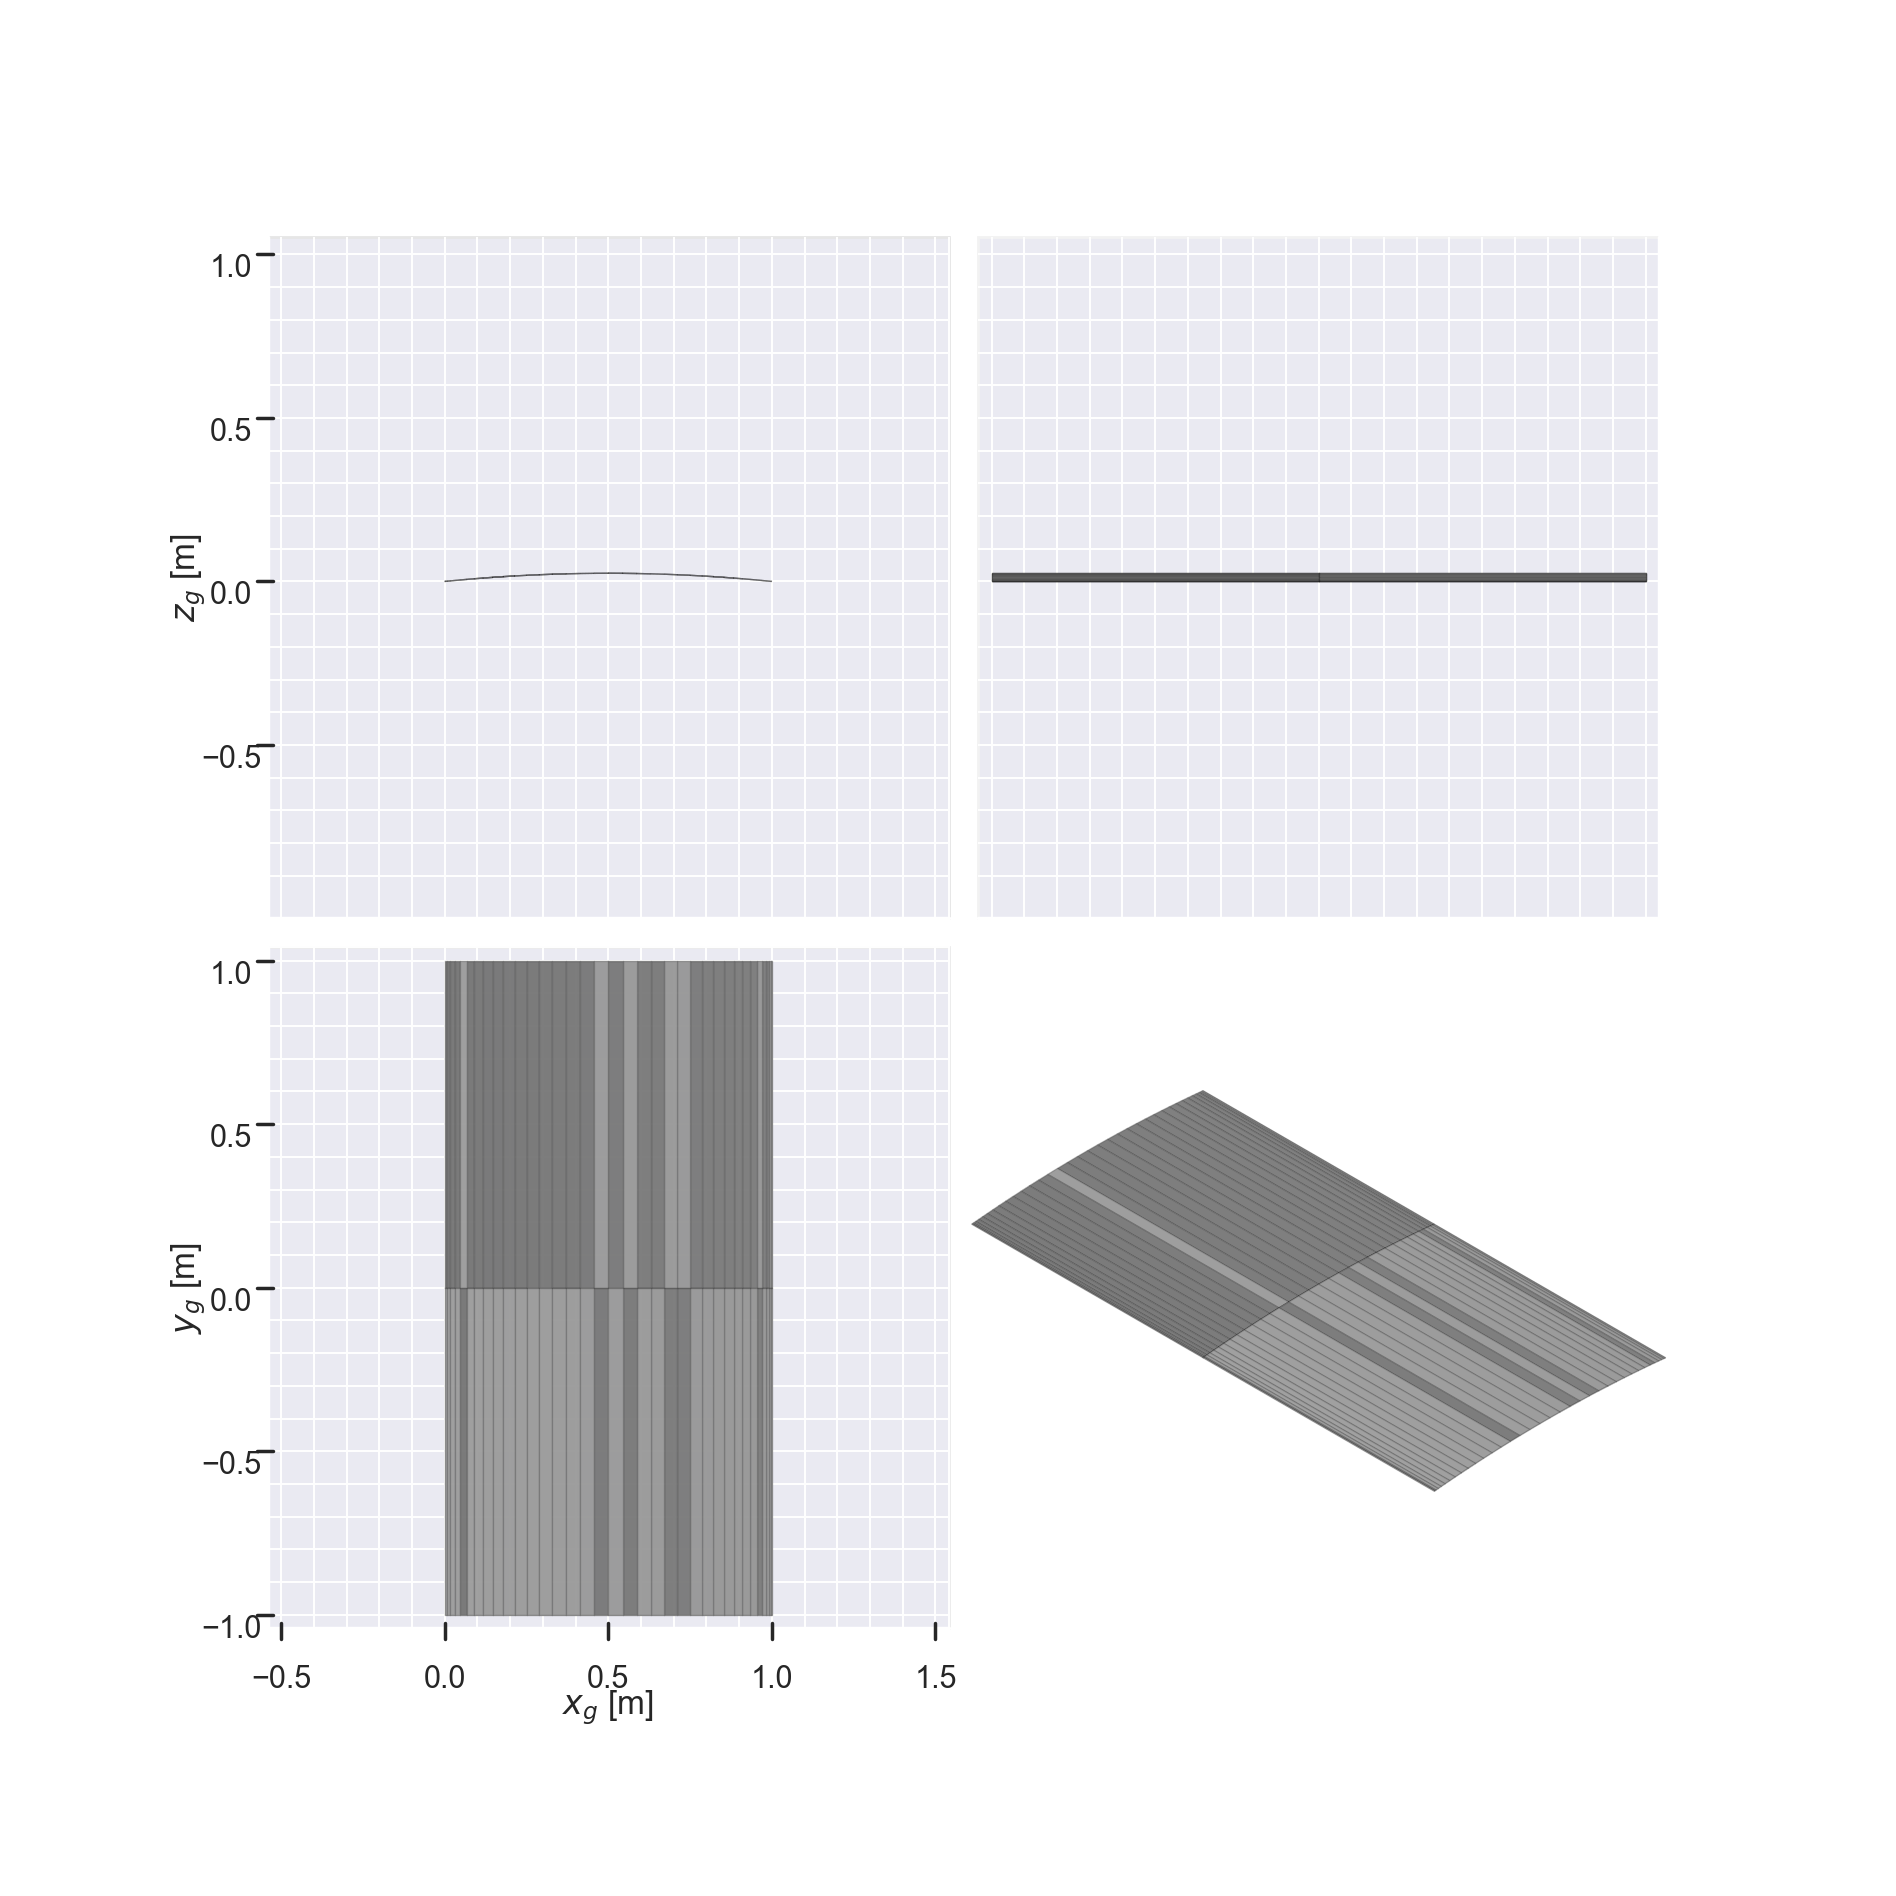

xyz_le: [0.8848173622072579, 0.15922809819834116, 0.782173418572774]
chord: 1.4210682859975485
twist: -0.4594550513568827
Airfoil upper_weights: [1.5577557  5.49826888 4.3772947  1.96141979 7.32571581 5.80861994]
Airfoil lower_weights: [2.57297831 0.1807492  1.55115797 0.0778122  2.82948081 2.58815957]
Airfoil leading_edge_weight: 2.110558754002569
Airfoil N1: 7.877128361025484
Airfoil N2: 3.977603956180444
-----
xyz_le: [0. 1. 0.]
chord: 1
twist: 0
Airfoil upper_weights: [0.1 0.1 0.1 0.1 0.1 0.1]
Airfoil lower_weights: [0.1 0.1 0.1 0.1 0.1 0.1]
Airfoil leading_edge_weight: 0
Airfoil N1: 1
Airfoil N2: 1
-----
xyz_le: [0.8848173622072579, 0.15922809819834116, 0.782173418572774]
chord: 1.4210682859975485
twist: -0.4594550513568827
Airfoil upper_weights: [1.5577557  5.49826888 4.3772947  1.96141979 7.32571581 5.80861994]
Airfoil lower_weights: [2.57297831 0.1807492  1.55115797 0.0778122  2.82948081 2.58815957]
Airfoil leading_edge_weight: 2.110558754002569
Airfoil N1: 7.877128361025484
Ai

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [91]:
env = AeroEnv()
episodes = 50

for episode in range(episodes):
    done = False
    obs = env.reset()
    while True:  # not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)